In [1]:
#Imported libraries
import tensorflow as tf 
import numpy as np 
import os

In [2]:
# Paths 
base_path = '/Users/whybless/ai/computer_vision/image_classification'


# Training pictures
train_path = os.path.join(base_path,'seg_train')
train_buildings = os.path.join(base_path,'seg_train/buildings')
train_forest = os.path.join(base_path,'seg_train/forest')
train_glacier = os.path.join(base_path,'seg_train/glacier')
train_mountain = os.path.join(base_path,'seg_train/mountain')
train_sea = os.path.join(base_path,'seg_train/sea')
train_street = os.path.join(base_path,'seg_train/street')

#validation pictures
validation_path = os.path.join(base_path,'seg_pred')
validation_buildings = os.path.join(base_path, 'seg_pred/buildings')
validation_forest = os.path.join(base_path, 'seg_pred/forest')
validation_glacier = os.path.join(base_path, 'seg_pred/glacier')
validation_mountain = os.path.join(base_path, 'seg_pred/mountain')
validation_sea = os.path.join(base_path, 'seg_pred/sea')
validation_street = os.path.join(base_path, 'seg_pred/street')

# Test pictures 
test_path = os.path.join(base_path,'seg_test')
test_buildings = os.path.join(base_path, 'seg_test/buildings')
test_forest = os.path.join(base_path, 'seg_test/forest')
test_glacier = os.path.join(base_path, 'seg_test/glacier')
test_mountain = os.path.join(base_path, 'seg_test/mountain')
test_sea = os.path.join(base_path, 'seg_test/sea')
test_street = os.path.join(base_path, 'seg_test/street')



In [3]:
from keras.preprocessing.image import ImageDataGenerator
# Data preprocessing using ImageDataGenerator
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    base_path + '/seg_train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    base_path + '/seg_pred',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    base_path + '/seg_test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 14034 images belonging to 1 classes.
Found 7301 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.


In [4]:
#Model Selection

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.layers import Dropout

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, BatchNormalization

# Load pre-trained ResNet model
resnet_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in resnet_model.layers:
    layer.trainable = False

# Define model
model = models.Sequential()

# Add the ResNet model as a layer
model.add(resnet_model)

# Add additional layers on top of ResNet
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [5]:
# Compile the model
from keras.optimizers import Adam
learning_rate = 0.001
clipvalue=1.0
optimizer=Adam(learning_rate=learning_rate, clipvalue=clipvalue)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         4718848   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 256)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 512)         1180160   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 512)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 1024)        4

In [7]:
#Early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [8]:
# Training
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20
244/438 [===============>..............] - ETA: 3:17 - loss: 4145125376.0000 - accuracy: 0.1811

KeyboardInterrupt: 

In [15]:
# Save the trained model
model.save('image_classification_model.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


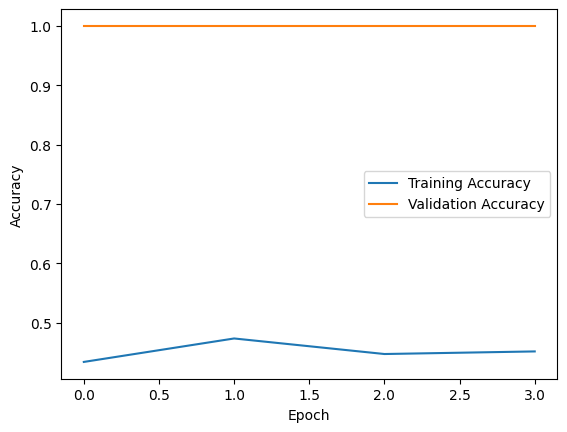

In [ ]:
# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Testing

trained_model = keras.models.load_model('image_classification_model.h5')

# Create a new test generator
test_generator = test_datagen.flow_from_directory(
    base_path + '/seg_test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3000 images belonging to 1 classes.


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = trained_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

24/24 [==============================] - 76s 3s/step - loss: 2700020224.0000 - accuracy: 1.0000
Test Accuracy: 1.0
